<a href="https://colab.research.google.com/github/batu-el/l65_be301_dc755/blob/main/Notebook0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install networkx
    !pip install lovely-tensors

Installing PyTorch Geometric
Installing other libraries


In [9]:
import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, LayerNorm, Module, ModuleList, Sequential
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MultiheadAttention
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, dense_to_sparse, to_dense_batch, to_dense_adj

from torch_geometric.nn import GCNConv, GATConv

from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import lovely_tensors as lt
lt.monkey_patch()

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.5.0


In [10]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [11]:
# Download and load Cora dataset
dataset = 'Cora'
# transform = T.Compose([T.NormalizeFeatures(), T.GCNNorm(), T.ToSparseTensor()])
dataset = Planetoid('/tmp/Cora', dataset)
data = dataset[0]

In [12]:
# adjacency matrices for Cora
A = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
A_tilde = A + torch.eye(A.shape[0])
D_tilde = torch.diag(torch.sum(A_tilde, axis=1))
D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
A_tilde = A_tilde.to_sparse()
D_tilde_inv_sqrt = D_tilde_inv_sqrt.to_sparse()
adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency
L = torch.eye(adj_norm.shape[0]) - adj_norm  # graph laplacian


<ipython-input-12-7c619b8bf941>:9: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency


In [17]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

<ipython-input-5-449309cf93f5>:9: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency


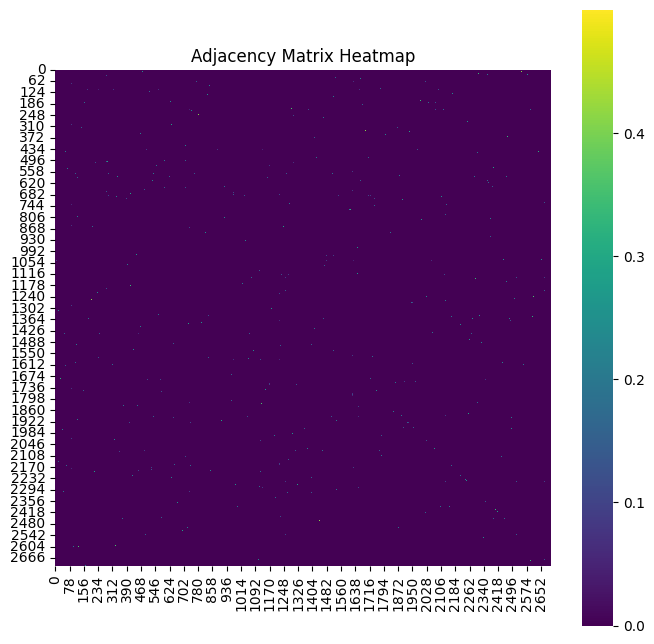

In [ ]:
# adjacency matrices for Cora
A = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
A_tilde = A + torch.eye(A.shape[0])
D_tilde = torch.diag(torch.sum(A_tilde, axis=1))
D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
A_tilde = A_tilde.to_sparse()
D_tilde_inv_sqrt = D_tilde_inv_sqrt.to_sparse()
adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency
L = torch.eye(adj_norm.shape[0]) - adj_norm  # graph laplacian

# # Eigenvectors with numpy
# EigVal, EigVec = np.linalg.eig(L)
# idx = EigVal.argsort() # sort in increasing order
# EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])

plt.figure(figsize=(8, 8))
sns.heatmap(adj_norm.to_dense().numpy(), cmap='viridis', square=True)
plt.title('Adjacency Matrix Heatmap')
plt.show()

In [16]:
adj_norm.to_dense().numpy()

array([[0.25      , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.20412414, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.20412414, 0.16666666, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.49999997, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.19999999,
        0.19999999],
       [0.        , 0.        , 0.        , ..., 0.        , 0.19999999,
        0.19999999]], dtype=float32)

In [ ]:
# PyG example code: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gcn2_cora.py

class GNNModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # GCNConv(hidden_dim, hidden_dim)
                GATConv(hidden_dim, hidden_dim // num_heads, num_heads)
            )
        self.dropout = dropout

    def forward(self, x, edge_index):

        x = self.lin_in(x)

        for layer in self.layers:
            # conv -> activation ->  dropout -> residual
            x_in = x
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNNModel().to(device)

data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.edge_index).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9564 Train: 0.4143, Val: 0.1540, Test: 0.1650, Final Test: 0.1650
Epoch: 0002, Loss: 1.8827 Train: 0.7071, Val: 0.2200, Test: 0.2460, Final Test: 0.2460
Epoch: 0003, Loss: 1.8154 Train: 0.8929, Val: 0.2880, Test: 0.3280, Final Test: 0.3280
Epoch: 0004, Loss: 1.7430 Train: 0.9214, Val: 0.3480, Test: 0.4090, Final Test: 0.4090
Epoch: 0005, Loss: 1.6689 Train: 0.9571, Val: 0.4020, Test: 0.4590, Final Test: 0.4590
Epoch: 0006, Loss: 1.5866 Train: 0.9857, Val: 0.4600, Test: 0.4970, Final Test: 0.4970
Epoch: 0007, Loss: 1.5064 Train: 0.9929, Val: 0.4960, Test: 0.5360, Final Test: 0.5360
Epoch: 0008, Loss: 1.4049 Train: 0.9929, Val: 0.5420, Test: 0.5630, Final Test: 0.5630
Epoch: 0009, Loss: 1.3038 Train: 0.9929, Val: 0.5700, Test: 0.5910, Final Test: 0.5910
Epoch: 0010, Loss: 1.2217 Train: 0.9929, Val: 0.6120, Test: 0.6130, Final Test: 0.6130
Epoch: 0011, Loss: 1.0937 Train: 0.9929, Val: 0.6320, Test: 0.6360, Final Test: 0.6360
Epoch: 0012, Loss: 0.9883 Train: 0.9929, Va

In [ ]:
class SparseGraphTransformerModel(Module):
    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 1,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        self.dropout = dropout

    def forward(self, x, dense_adj):

        x = self.lin_in(x)

        # TransformerEncoder
        # x = self.encoder(x, mask = ~dense_adj.bool())

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # boolean mask enforces graph structure
            # x = layer(x, src_mask = ~dense_adj.bool())

            # MHSA layer
            # boolean mask enforces graph structure
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = ~dense_adj.bool(),
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SparseGraphTransformerModel().to(device)

data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.dense_adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.dense_adj).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9423 Train: 0.5286, Val: 0.2440, Test: 0.2290, Final Test: 0.2290
Epoch: 0002, Loss: 1.8869 Train: 0.8714, Val: 0.3320, Test: 0.3330, Final Test: 0.3330
Epoch: 0003, Loss: 1.8313 Train: 0.9571, Val: 0.4140, Test: 0.3980, Final Test: 0.3980
Epoch: 0004, Loss: 1.7772 Train: 0.9929, Val: 0.4840, Test: 0.4590, Final Test: 0.4590
Epoch: 0005, Loss: 1.7156 Train: 1.0000, Val: 0.5400, Test: 0.5180, Final Test: 0.5180
Epoch: 0006, Loss: 1.6639 Train: 1.0000, Val: 0.5620, Test: 0.5560, Final Test: 0.5560
Epoch: 0007, Loss: 1.6077 Train: 1.0000, Val: 0.5900, Test: 0.5800, Final Test: 0.5800
Epoch: 0008, Loss: 1.5403 Train: 1.0000, Val: 0.6120, Test: 0.6050, Final Test: 0.6050
Epoch: 0009, Loss: 1.4787 Train: 1.0000, Val: 0.6300, Test: 0.6230, Final Test: 0.6230
Epoch: 0010, Loss: 1.4187 Train: 1.0000, Val: 0.6380, Test: 0.6330, Final Test: 0.6330
Epoch: 0011, Loss: 1.3437 Train: 1.0000, Val: 0.6500, Test: 0.6480, Final Test: 0.6480
Epoch: 0012, Loss: 1.2613 Train: 1.0000, Va

In [ ]:
# The Shape of the Attention Matrix
model.attn_weights_list

[tensor[1, 2708, 2708] n=7333264 (28Mb) x∈[0., 1.000] μ=0.000 σ=0.013 cuda:0]

In [ ]:
# Confirm that the Adjacency and the Attention Matrices have the same shape
ATTENTION_MATRIX = model.attn_weights_list[0].detach().cpu().numpy().squeeze()
ADJACENCY = data.dense_adj.cpu().numpy()
ADJACENCY.shape, ATTENTION_MATRIX

((2708, 2708),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.3203308 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.22553712, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.22934002],
        [0.        , 0.        , 0.        , ..., 0.        , 0.23368035,
         0.        ]], dtype=float32))

In [ ]:
# The symmetry of the Attention Matrix: We find that the Attention Matrix is Not Symmetric because of Softmax Normalization (?)
ATTENTION_MATRIX.sum(axis=0), ATTENTION_MATRIX.sum(axis=1)

(array([0.8954279, 1.7106514, 1.6886796, ..., 1.       , 1.1203785,
        0.7661645], dtype=float32),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [ ]:
### Node Degree Distribution - Before Tresholding (Probabilistic?)
pd.DataFrame(pd.concat({'Attention':pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts(), 'Adjacency': pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()}, axis=1)).fillna(0)

,Attention,Adjacency
0,,
1.0,2336.0,485.0
1.0,244.0,0.0
1.0,66.0,0.0
1.0,61.0,0.0
1.0,1.0,0.0
2.0,0.0,583.0
3.0,0.0,553.0
4.0,0.0,389.0
5.0,0.0,281.0


In [ ]:
### Thresholding by 0
treshold = 0.1
ATTENTION_MATRIX[ ATTENTION_MATRIX > treshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX <= treshold] = 0

In [ ]:
### Node Degree Distribution
pd.DataFrame(pd.concat({'Attention':pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts(), 'Adjacency': pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()}, axis=1)).fillna(0)

,Attention,Adjacency
0,,
2.0,590.0,583.0
3.0,563.0,553.0
1.0,492.0,485.0
4.0,409.0,389.0
5.0,295.0,281.0
6.0,147.0,131.0
7.0,94.0,82.0
0.0,74.0,0.0
8.0,37.0,57.0


done
done


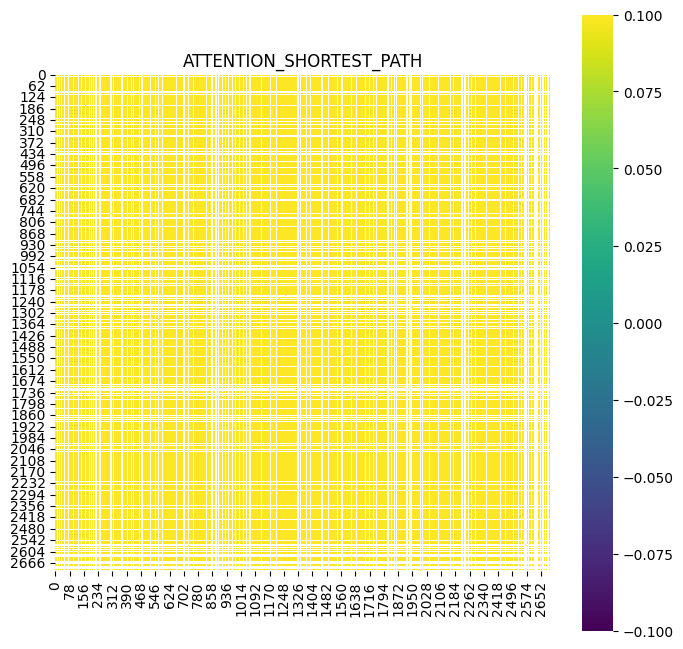

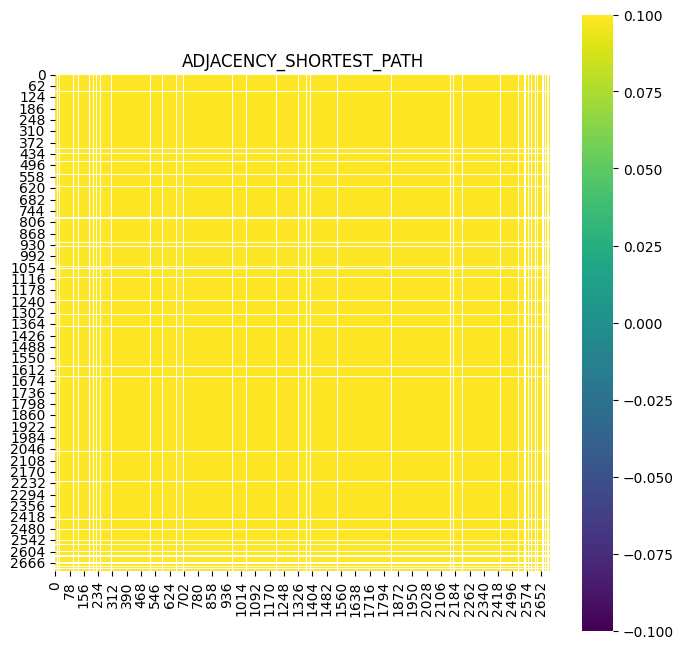

In [ ]:
## Shortest Paths

def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

ATTENTION_SHORTEST_PATH = get_shortest_path_matrix(ATTENTION_MATRIX)
print('done')
ADJACENCY_SHORTEST_PATH = get_shortest_path_matrix(ADJACENCY)
print('done')
ATTENTION_SHORTEST_PATH[ATTENTION_SHORTEST_PATH != np.inf].max(), ADJACENCY_SHORTEST_PATH[ADJACENCY_SHORTEST_PATH != np.inf].max()

plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_SHORTEST_PATH.numpy(), cmap='viridis', square=True)
plt.title('ATTENTION_SHORTEST_PATH')
plt.show()

plt.figure(figsize=(8, 8))
sns.heatmap(ADJACENCY_SHORTEST_PATH.numpy(), cmap='viridis', square=True)
plt.title('ADJACENCY_SHORTEST_PATH')
plt.show()

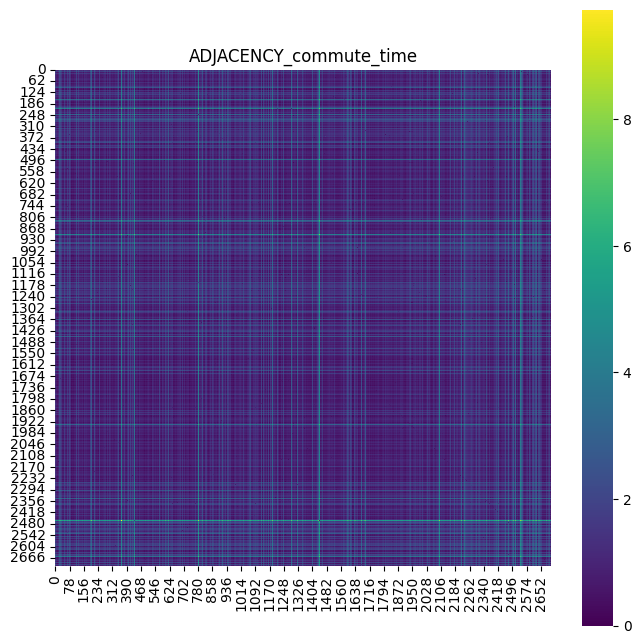

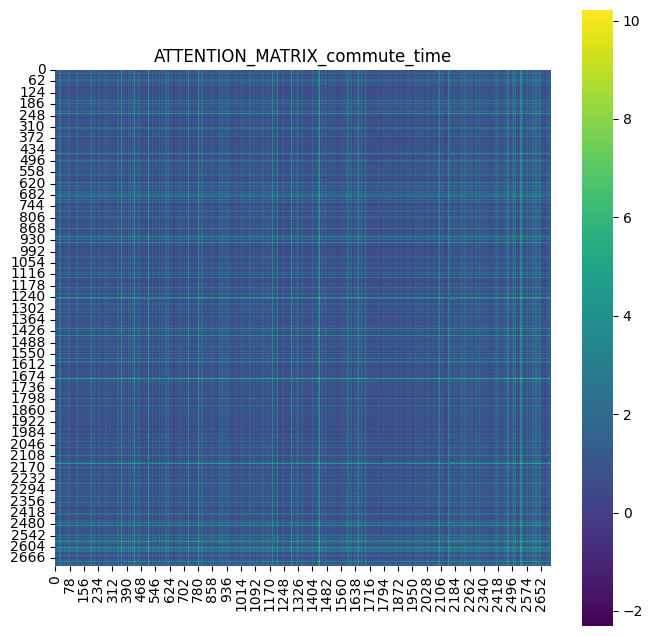

Attention 1.3108155973372904 0.8957792660594283 -2.307417869567871 10.215825208229944
Adjacency 1.3911518623645946 0.7920071111234148 0.0 9.730179071426392


In [ ]:
### Commute Times

# ref: https://math.stackexchange.com/questions/1321305/commute-time-distance-in-a-graph
import numpy as np
from scipy.linalg import pinv

def compute_commute_times(A):
    n = A.shape[0]  # Number of vertices
    D = np.diag(A.sum(axis=1))  # Degree matrix
    L = D - A  # Laplacian matrix
    L_pinv = pinv(L)  # Pseudoinverse of the Laplacian
    # V = np.sum(A) / 2  # Total number of edges, for undirected graph

    commute_times = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            commute_times[i, j] =(L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]) # V * (L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j])

    return commute_times

ADJACENCY_commute_time = compute_commute_times(ADJACENCY)
ATTENTION_MATRIX_commute_time = compute_commute_times(ATTENTION_MATRIX)

plt.figure(figsize=(8, 8))
sns.heatmap(ADJACENCY_commute_time, cmap='viridis', square=True)
plt.title('ADJACENCY_commute_time')
plt.show()

plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_MATRIX_commute_time, cmap='viridis', square=True)
plt.title('ATTENTION_MATRIX_commute_time')
plt.show()


print('Attention', ATTENTION_MATRIX_commute_time.mean(), ATTENTION_MATRIX_commute_time.std(), ATTENTION_MATRIX_commute_time.min(), ATTENTION_MATRIX_commute_time.max())
print('Adjacency',ADJACENCY_commute_time.mean(), ADJACENCY_commute_time.std(), ADJACENCY_commute_time.min(), ADJACENCY_commute_time.max())

In [ ]:
### Topological substructures: Triangle Count

A = ATTENTION_MATRIX
A_cubed = np.linalg.matrix_power(A, 3)
print('Attention:', np.trace(A_cubed))

A = ADJACENCY
A_cubed = np.linalg.matrix_power(A, 3)
print('Adjacency:',np.trace(A_cubed))

Attention: 3522.0
Adjacency: 9780.0


<ipython-input-17-33000d86f661>:8: RuntimeWarning: invalid value encountered in divide
  P = A / row_sums


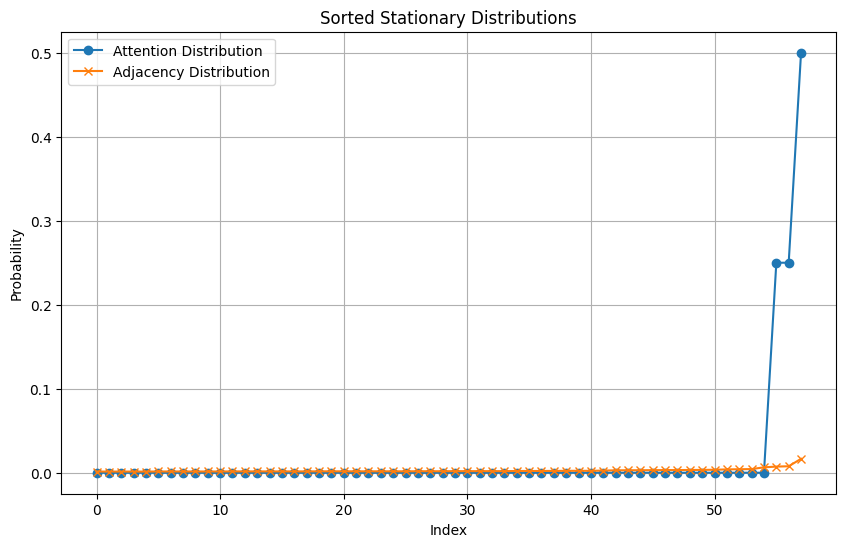

Attention 0.0003692762 0.011761897 -2.2795222e-14 0.5
Adjacency 0.0003692762 0.0005225877 -4.880632e-11 0.016571317


In [ ]:
### Random Walk Statistics

import numpy as np

A = ATTENTION_MATRIX
# Convert to transition matrix P
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
# Calculate stationary distribution
# We solve (pi*P = pi) by finding the eigenvector of P.T corresponding to eigenvalue 1
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_attention = stationary_distribution


# Sample adjacency matrix
A = ADJACENCY
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_adjacency = stationary_distribution

cutoff = 2650
y1 = np.sort(stationary_distribution_attention)[cutoff:]
y2 = np.sort(stationary_distribution_adjacency)[cutoff:]
x = np.array(range(len(y1)))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Attention Distribution', marker='o')
plt.plot(x, y2, label='Adjacency Distribution', marker='x')
plt.title('Sorted Stationary Distributions')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

print('Attention', stationary_distribution_attention.mean(), stationary_distribution_attention.std(), stationary_distribution_attention.min(), stationary_distribution_attention.max())
print('Adjacency',stationary_distribution_adjacency.mean(), stationary_distribution_adjacency.std(), stationary_distribution_adjacency.min(), stationary_distribution_adjacency.max())

# DENSE GRAPH TRANSFORMER

In [ ]:
# import tqdm

# num_layers = len(model.attn_weights_list)
# num_heads = model.attn_weights_list[0].shape[0]

# fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

# for layer_idx in range(num_layers):
#     for head_idx in tqdm.tqdm(range(num_heads)):
#         ax = axes[layer_idx, head_idx]

#         # Extract the attention heatmap for the current layer and head
#         attn_heatmap = model.attn_weights_list[layer_idx][head_idx, :, :].cpu().numpy()

#         # Plot the heatmap on the current subplot
#         sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

#         ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
#         ax.axis('off')

# plt.suptitle('Attention Heatmaps', y=1.02)
# plt.tight_layout()
# plt.show()

In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
dense_shortest_path_matrix = get_shortest_path_matrix(dense_adj)  # takes about 1-2 mins

In [ ]:
class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            pos_enc_dim: int = 16,
            hidden_dim: int = 128,
            num_heads: int = 4,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )


        self.attn_bias_scale = torch.nn.Parameter(torch.tensor([10.0]))  # controls how much we initially bias our model to nearby nodes
        self.dropout = dropout

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = self.attn_bias_scale * torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0
        )
        #attn_bias = torch.ones_like(attn_bias)

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # float mask adds learnable additive attention bias
            # x = layer(x, src_mask = attn_bias)

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseGraphTransformerModel().to(device)

data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
# data = T.AddRandomWalkPE(walk_length = 16, attr_name = 'pos_enc')(data)
data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data.dense_sp_matrix = dense_shortest_path_matrix.float()  # pre-computed in previous cell
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.pos_enc, data.dense_sp_matrix)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.pos_enc, data.dense_sp_matrix).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Notes
# - Dense Transformer needs to be trained for a bit longer to reach low loss value
# - Node positional encodings are not particularly useful
# - Edge distance encodings are very useful
# - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes

Epoch: 0001, Loss: 1.9493 Train: 0.4571, Val: 0.2440, Test: 0.2310, Final Test: 0.2310
Epoch: 0002, Loss: 1.8906 Train: 0.8286, Val: 0.3320, Test: 0.3280, Final Test: 0.3280
Epoch: 0003, Loss: 1.8302 Train: 0.9571, Val: 0.4460, Test: 0.4310, Final Test: 0.4310
Epoch: 0004, Loss: 1.7705 Train: 0.9857, Val: 0.5160, Test: 0.5110, Final Test: 0.5110
Epoch: 0005, Loss: 1.7104 Train: 1.0000, Val: 0.5780, Test: 0.5670, Final Test: 0.5670
Epoch: 0006, Loss: 1.6460 Train: 1.0000, Val: 0.6280, Test: 0.6050, Final Test: 0.6050
Epoch: 0007, Loss: 1.5721 Train: 1.0000, Val: 0.6620, Test: 0.6410, Final Test: 0.6410
Epoch: 0008, Loss: 1.5033 Train: 1.0000, Val: 0.6900, Test: 0.6640, Final Test: 0.6640
Epoch: 0009, Loss: 1.4225 Train: 1.0000, Val: 0.7040, Test: 0.6850, Final Test: 0.6850
Epoch: 0010, Loss: 1.3255 Train: 1.0000, Val: 0.7040, Test: 0.7020, Final Test: 0.6850
Epoch: 0011, Loss: 1.2293 Train: 1.0000, Val: 0.7140, Test: 0.7140, Final Test: 0.7140
Epoch: 0012, Loss: 1.1330 Train: 1.0000, Va

In [ ]:
# import tqdm

# num_layers = len(model.attn_weights_list)
# num_heads = model.attn_weights_list[0].shape[0]

# fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

# for layer_idx in range(num_layers):
#     for head_idx in tqdm.tqdm(range(num_heads)):
#         ax = axes[layer_idx, head_idx]

#         # Extract the attention heatmap for the current layer and head
#         attn_heatmap = model.attn_weights_list[layer_idx].cpu().numpy()[head_idx]

#         # Plot the heatmap on the current subplot
#         sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

#         ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
#         ax.axis('off')

# plt.suptitle('Attention Heatmaps', y=1.02)
# plt.tight_layout()
# plt.show()

In [ ]:
# The Shape of the Attention Matrix
model.attn_weights_list

[tensor[4, 2708, 2708] n=29333056 (0.1Gb) x∈[2.755e-12, 1.000] μ=0.000 σ=0.010 cuda:0,
 tensor[4, 2708, 2708] n=29333056 (0.1Gb) x∈[9.730e-13, 1.000] μ=0.000 σ=0.010 cuda:0,
 tensor[4, 2708, 2708] n=29333056 (0.1Gb) x∈[2.922e-16, 1.000] μ=0.000 σ=0.011 cuda:0]

In [ ]:
# Confirm that the Adjacency and the Attention Matrices have the same shape
ATTENTION_MATRIX = model.attn_weights_list[0].detach().cpu().numpy().squeeze()
ADJACENCY = data.dense_adj.cpu().numpy()
ADJACENCY.shape, ATTENTION_MATRIX

((2708, 2708),
 array([[[1.20891918e-05, 8.93261895e-05, 1.58210605e-04, ...,
          5.31999778e-10, 6.18831764e-05, 8.70038493e-05],
         [5.16775253e-05, 1.41460105e-05, 2.74728358e-01, ...,
          3.10969528e-10, 6.00209460e-05, 6.03485096e-05],
         [6.42303348e-05, 2.09015161e-01, 8.64820959e-06, ...,
          2.42884712e-10, 7.20029202e-05, 7.03788537e-05],
         ...,
         [1.80072957e-09, 1.86609839e-09, 1.92618677e-09, ...,
          4.85826276e-05, 1.88938132e-09, 1.78666504e-09],
         [5.11121689e-05, 7.53500281e-05, 1.22494894e-04, ...,
          4.07001238e-10, 9.62714967e-06, 2.18930885e-01],
         [6.48916393e-05, 7.95647720e-05, 1.27347957e-04, ...,
          3.93882565e-10, 2.06240252e-01, 9.09982100e-06]],
 
        [[1.31512415e-05, 8.20531932e-05, 1.51830129e-04, ...,
          5.00084363e-10, 6.65244734e-05, 8.16212050e-05],
         [6.10886273e-05, 1.34605216e-05, 2.84133554e-01, ...,
          3.58256202e-10, 6.41614679e-05, 6.5545842

In [ ]:
# The symmetry of the Attention Matrix: We find that the Attention Matrix is Not Symmetric because of Softmax Normalization (?)
ATTENTION_MATRIX.sum(axis=0), ATTENTION_MATRIX.sum(axis=1)

(array([[4.9781873e-05, 3.3563332e-04, 6.0210790e-04, ..., 2.0514852e-09,
         2.5227666e-04, 3.4163255e-04],
        [1.9634113e-04, 6.0837836e-05, 1.1092138e+00, ..., 1.2251250e-09,
         2.3004343e-04, 2.3466765e-04],
        [2.5012551e-04, 8.7124991e-01, 3.8536033e-05, ..., 9.3713948e-10,
         2.7683889e-04, 2.7393739e-04],
        ...,
        [7.5372899e-09, 7.4481816e-09, 7.8402937e-09, ..., 1.8973861e-04,
         7.6802404e-09, 7.4536999e-09],
        [2.0625121e-04, 3.1209076e-04, 5.1382685e-04, ..., 1.6278425e-09,
         3.9120805e-05, 8.6003786e-01],
        [2.6103231e-04, 3.1564693e-04, 4.9988687e-04, ..., 1.5610436e-09,
         8.2411170e-01, 3.6709906e-05]], dtype=float32),
 array([[0.88486123, 1.6255163 , 1.6860586 , ..., 1.0000019 , 1.1531053 ,
         0.8845451 ],
        [0.8693788 , 1.5099763 , 1.6454201 , ..., 0.9999988 , 1.146518  ,
         0.84954435],
        [0.88165665, 1.8571448 , 1.8415079 , ..., 0.9999968 , 1.1602858 ,
         0.8885819 ]

In [ ]:
### Node Degree Distribution - Before Tresholding (Probabilistic?)
ATTENTION_MATRIX_FULL = ATTENTION_MATRIX
ATTENTION_MATRIX = ATTENTION_MATRIX[0]
pd.DataFrame(pd.concat({'Attention':pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts(), 'Adjacency': pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()}, axis=1)).fillna(0)

,Attention,Adjacency
0,,
1.000000,1092.0,485.0
1.000000,477.0,0.0
1.000000,383.0,0.0
1.000000,316.0,0.0
1.000000,178.0,0.0
1.000000,93.0,0.0
1.000000,70.0,0.0
1.000000,26.0,0.0
1.000000,18.0,0.0


In [ ]:
### Thresholding by 0
treshold = 0.1
ATTENTION_MATRIX[ ATTENTION_MATRIX > treshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX <= treshold] = 0

In [ ]:
### Node Degree Distribution
pd.DataFrame(pd.concat({'Attention':pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts(), 'Adjacency': pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()}, axis=1)).fillna(0)

,Attention,Adjacency
0,,
2.0,591.0,583.0
3.0,563.0,553.0
1.0,498.0,485.0
4.0,399.0,389.0
5.0,289.0,281.0
6.0,134.0,131.0
0.0,110.0,0.0
7.0,86.0,82.0
8.0,36.0,57.0


done
done


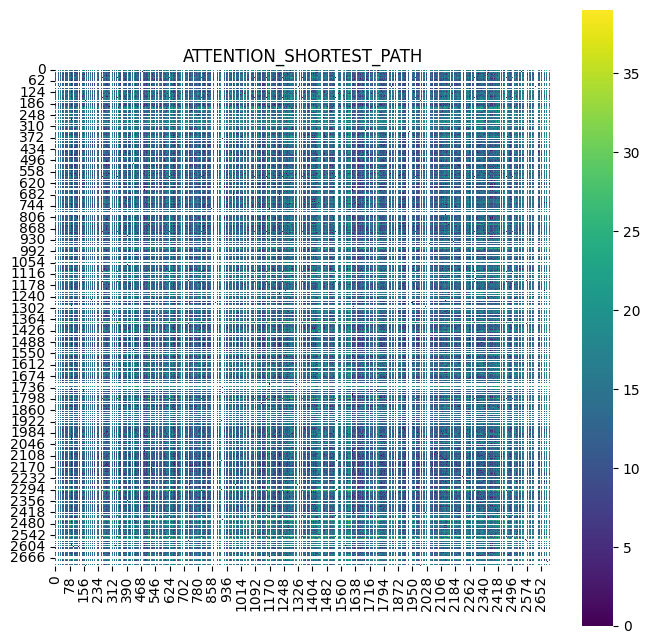

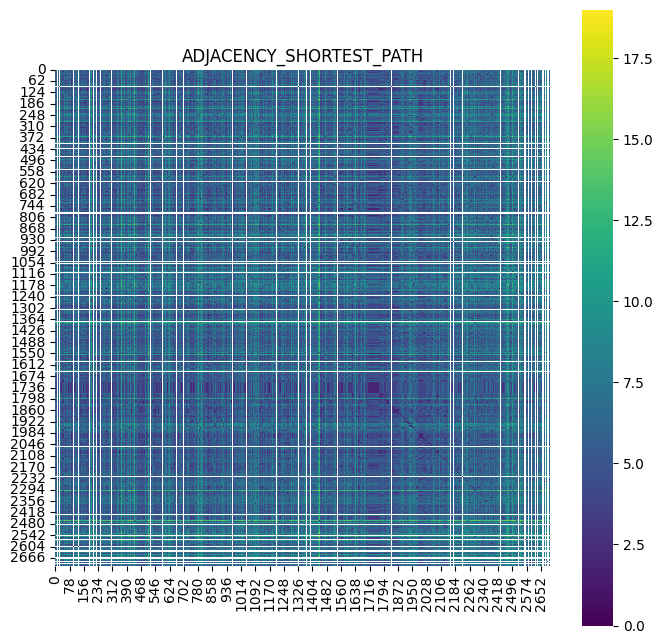

In [ ]:
## Shortest Paths

def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

ATTENTION_SHORTEST_PATH = get_shortest_path_matrix(ATTENTION_MATRIX)
print('done')
ADJACENCY_SHORTEST_PATH = get_shortest_path_matrix(ADJACENCY)
print('done')
ATTENTION_SHORTEST_PATH[ATTENTION_SHORTEST_PATH != np.inf].max(), ADJACENCY_SHORTEST_PATH[ADJACENCY_SHORTEST_PATH != np.inf].max()

plt.figure(figsize=(8, 8))
sns.heatmap(np.array(pd.DataFrame(ATTENTION_SHORTEST_PATH.numpy()).replace(np.inf, np.nan)), cmap='viridis', square=True)
plt.title('ATTENTION_SHORTEST_PATH')
plt.show()

plt.figure(figsize=(8, 8))
sns.heatmap(np.array(pd.DataFrame(ADJACENCY_SHORTEST_PATH.numpy()).replace(np.inf, np.nan)), cmap='viridis', square=True)
plt.title('ADJACENCY_SHORTEST_PATH')
plt.show()

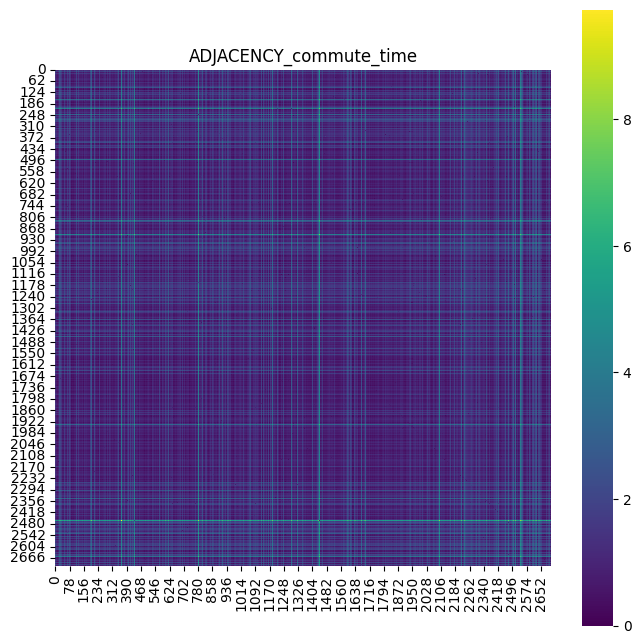

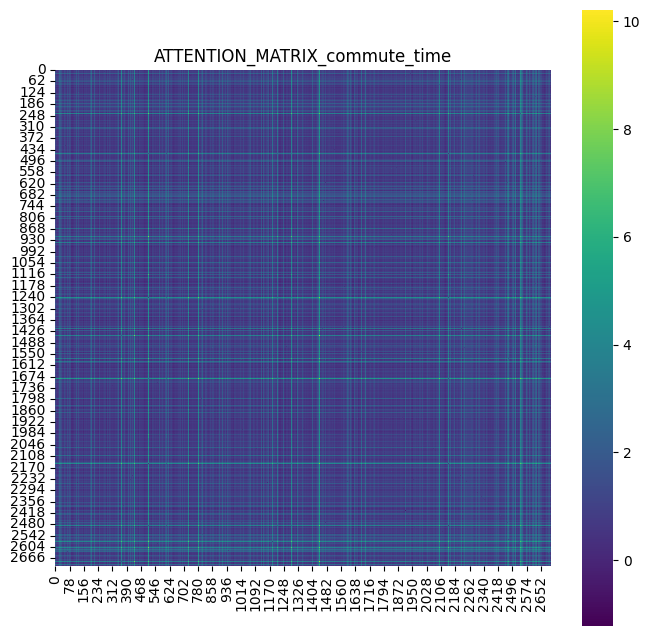

Attention 1.2763308750289908 0.8865919845200345 -1.2244822978973389 10.209822152275592
Adjacency 1.3911518623645946 0.7920071111234148 0.0 9.730179071426392


In [ ]:
### Commute Times

# ref: https://math.stackexchange.com/questions/1321305/commute-time-distance-in-a-graph
import numpy as np
from scipy.linalg import pinv

def compute_commute_times(A):
    n = A.shape[0]  # Number of vertices
    D = np.diag(A.sum(axis=1))  # Degree matrix
    L = D - A  # Laplacian matrix
    L_pinv = pinv(L)  # Pseudoinverse of the Laplacian
    # V = np.sum(A) / 2  # Total number of edges, for undirected graph

    commute_times = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            commute_times[i, j] =(L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]) # V * (L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j])

    return commute_times

ADJACENCY_commute_time = compute_commute_times(ADJACENCY)
ATTENTION_MATRIX_commute_time = compute_commute_times(ATTENTION_MATRIX)

plt.figure(figsize=(8, 8))
sns.heatmap(ADJACENCY_commute_time, cmap='viridis', square=True)
plt.title('ADJACENCY_commute_time')
plt.show()

plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_MATRIX_commute_time, cmap='viridis', square=True)
plt.title('ATTENTION_MATRIX_commute_time')
plt.show()

print('Attention', ATTENTION_MATRIX_commute_time.mean(), ATTENTION_MATRIX_commute_time.std(), ATTENTION_MATRIX_commute_time.min(), ATTENTION_MATRIX_commute_time.max())
print('Adjacency',ADJACENCY_commute_time.mean(), ADJACENCY_commute_time.std(), ADJACENCY_commute_time.min(), ADJACENCY_commute_time.max())

In [ ]:
### Topological substructures: Triangle Count

A = ATTENTION_MATRIX
A_cubed = np.linalg.matrix_power(A, 3)
print('Attention:', np.trace(A_cubed))

A = ADJACENCY
A_cubed = np.linalg.matrix_power(A, 3)
print('Adjacency:',np.trace(A_cubed))

Attention: 3225.0
Adjacency: 9780.0


<ipython-input-71-ef12d4506b6e>:8: RuntimeWarning: invalid value encountered in divide
  P = A / row_sums


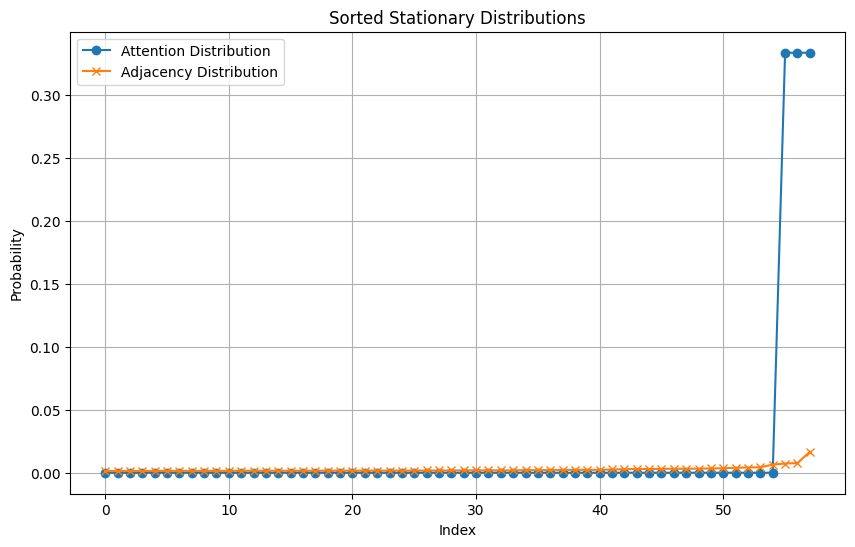

Attention 0.0003692762 0.011088538 -1.0238724e-15 0.3333333
Adjacency 0.0003692762 0.0005225877 -4.880632e-11 0.016571317


In [ ]:
### Random Walk Statistics

import numpy as np

A = ATTENTION_MATRIX
# Convert to transition matrix P
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
# Calculate stationary distribution
# We solve (pi*P = pi) by finding the eigenvector of P.T corresponding to eigenvalue 1
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
# pi_index = np.argmax(np.abs(eigenvalues)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_attention = stationary_distribution

# Sample adjacency matrix
A = ADJACENCY
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
# pi_index = np.argmax(np.abs(eigenvalues)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_adjacency = stationary_distribution

cutoff = 2650
y1 = np.sort(stationary_distribution_attention)[cutoff:]
y2 = np.sort(stationary_distribution_adjacency)[cutoff:]
x = np.array(range(len(y1)))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Attention Distribution', marker='o')
plt.plot(x, y2, label='Adjacency Distribution', marker='x')
plt.title('Sorted Stationary Distributions')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

print('Attention', stationary_distribution_attention.mean(), stationary_distribution_attention.std(), stationary_distribution_attention.min(), stationary_distribution_attention.max())
print('Adjacency',stationary_distribution_adjacency.mean(), stationary_distribution_adjacency.std(), stationary_distribution_adjacency.min(), stationary_distribution_adjacency.max())